### weight 초기화를 He Normal로 변경 후 성능 검증

In [1]:
import numpy as np
import pandas as pd

import os

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, train_labels.shape)

170508288/170498071 [==============================] - 3s 0us/step
train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (50000, 1)


In [3]:
train_images[0, :, :, :], train_labels[0, :]

(array([[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],
 
        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],
 
        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],
 
        ...,
 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],
 
        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],
 
        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
  

In [4]:
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
print(train_labels[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


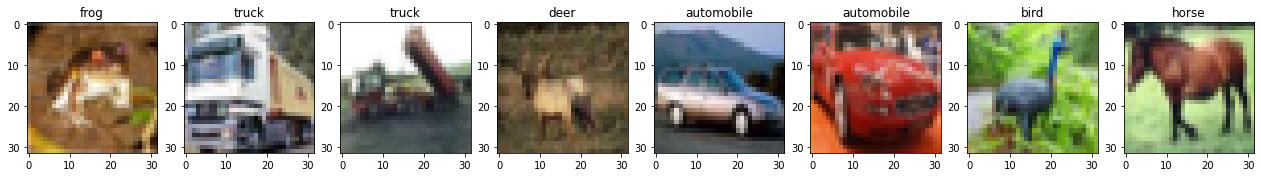

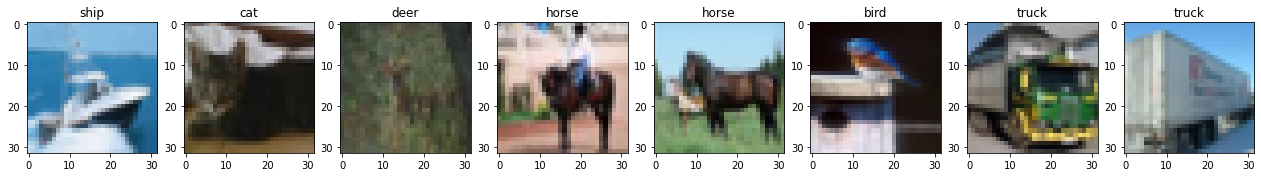

In [5]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

In [6]:
def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    labels = labels.squeeze()
    
    return images, labels

In [7]:
# 0~1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

In [8]:
IMAGE_SIZE=32

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개이므로 마지막 classification의 Dense layer units 갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()
                  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0     

In [10]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 47s 22ms/step - loss: 1.5581 - accuracy: 0.4256 - val_loss: 1.2070 - val_accuracy: 0.5736
Epoch 2/30
665/665 [==============================] - 14s 21ms/step - loss: 1.0965 - accuracy: 0.6091 - val_loss: 0.9264 - val_accuracy: 0.6740
Epoch 3/30
665/665 [==============================] - 14s 20ms/step - loss: 0.9113 - accuracy: 0.6805 - val_loss: 0.8193 - val_accuracy: 0.7123
Epoch 4/30
665/665 [==============================] - 14s 21ms/step - loss: 0.7913 - accuracy: 0.7227 - val_loss: 0.7796 - val_accuracy: 0.7317
Epoch 5/30
665/665 [==============================] - 14s 21ms/step - loss: 0.7184 - accuracy: 0.7480 - val_loss: 0.7550 - val_accuracy: 0.7423
Epoch 6/30
665/665 [==============================] - 14s 21ms/step - loss: 0.6385 - accuracy: 0.7750 - val_loss: 0.7149 - val_accuracy: 0.7571
Epoch 7/30
665/665 [==============================] - 14s 21ms/step - loss: 0.5849 - accuracy: 0.7959 - val_loss: 0.6791 - val_accuracy:

313/313 [==============================] - 3s 8ms/step - loss: 0.6928 - accuracy: 0.8099


[0.6927993893623352, 0.8098999857902527]

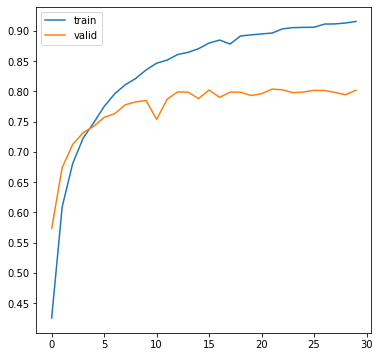

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1,0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_oh_labels)

In [13]:
# 테스트용 4차원 이미지 배열을 입력해서 predict() 수행
# predict()의 결과는 softmax 적용 결과. 학습 데이터의 원-핫 인코딩 적용 여부와 관계 없이 softmax 적용 결과는 무조건 2차원
preds = model.predict(np.expand_dims(test_images[0], axis=0))
print('예측 결과 shape:', preds.shape)
print('에측 결과:', preds)

예측 결과 shape: (1, 10)
에측 결과: [[5.7360314e-08 5.8046276e-13 4.6078178e-08 9.9928194e-01 2.9391254e-08
  6.6255487e-04 5.5094504e-05 8.8518446e-09 2.9895060e-07 7.2345720e-11]]


In [14]:
preds = model.predict(test_images[:32], batch_size=32)
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)

예측 결과 shape: (32, 10)
예측 결과: [[5.73591095e-08 5.80456148e-13 4.60772078e-08 9.99281943e-01
  2.93904154e-08 6.62545965e-04 5.50940349e-05 8.85170959e-09
  2.98948891e-07 7.23437907e-11]
 [1.61255389e-06 2.62063782e-04 8.60038191e-19 1.98310759e-14
  3.01451019e-17 7.10652965e-20 2.34663894e-12 9.38825358e-22
  9.99735773e-01 5.75811157e-07]
 [1.79760915e-03 8.52356702e-02 5.47367836e-06 3.76687967e-04
  3.54059353e-06 4.59304829e-07 1.62659679e-04 4.47731509e-07
  8.31077695e-01 8.13397691e-02]
 [9.65675414e-01 1.02496066e-03 1.96240493e-03 3.03437537e-05
  4.33369307e-03 1.29128739e-06 3.34759330e-04 1.11946918e-06
  2.53848750e-02 1.25095074e-03]
 [8.16210638e-14 6.06939013e-11 1.20606055e-05 1.49140078e-05
  5.38245672e-07 3.85187549e-10 9.99972463e-01 2.87263296e-14
  7.72072961e-10 2.06652599e-12]
 [2.75609023e-06 1.80217990e-06 3.24631180e-03 4.19310853e-02
  2.90512592e-02 1.10195540e-01 8.14741611e-01 7.44638208e-04
  4.83730128e-06 8.01282804e-05]
 [8.79649292e-07 9.98564065e-

In [15]:
predicted_class = np.argmax(preds, axis=1)
print('예측 클래스 값:', predicted_class)

예측 클래스 값: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 6 5 7 8 6 7 0 4 9 4 2 7 0 9 6 6 5]


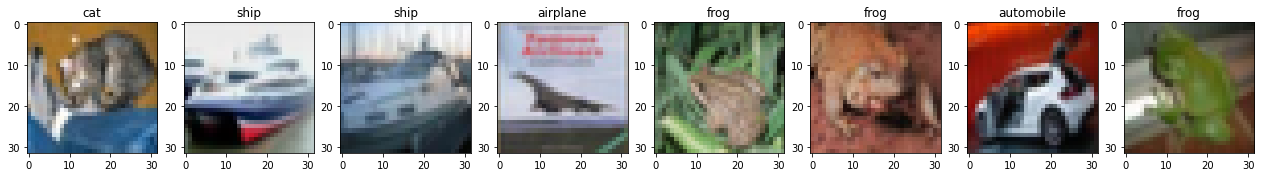

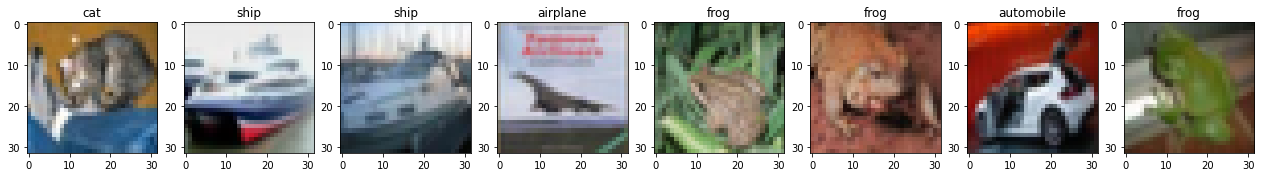

In [16]:
show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)

### Batch Normalization을 모델에 적용 후 성능 검증

- Batch Normalization 효과
1. 뛰어난 성능 향상 효과
2. Regularization 효과 -> 정규화 후에 스케일링, Shift로 일종의 Noise 추가 효과
3. 가중치 초기화(Weight Initialization) 설정을 크게 신경 쓸 필요 없음

In [17]:
from tensorflow.keras.layers import BatchNormalization

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units 갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0   

In [18]:
# label 값이 원-핫 인코딩이 아니므로 loss는 categorical_crossentropy임.
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 16s 22ms/step - loss: 1.5579 - accuracy: 0.4379 - val_loss: 1.4588 - val_accuracy: 0.4793
Epoch 2/30
665/665 [==============================] - 14s 21ms/step - loss: 1.1181 - accuracy: 0.6040 - val_loss: 1.3813 - val_accuracy: 0.5697
Epoch 3/30
665/665 [==============================] - 14s 21ms/step - loss: 0.9470 - accuracy: 0.6687 - val_loss: 0.8839 - val_accuracy: 0.6836
Epoch 4/30
665/665 [==============================] - 14s 21ms/step - loss: 0.8335 - accuracy: 0.7072 - val_loss: 0.8132 - val_accuracy: 0.7152
Epoch 5/30
665/665 [==============================] - 14s 21ms/step - loss: 0.7650 - accuracy: 0.7336 - val_loss: 0.8866 - val_accuracy: 0.7032
Epoch 6/30
665/665 [==============================] - 14s 21ms/step - loss: 0.6987 - accuracy: 0.7576 - val_loss: 0.7212 - val_accuracy: 0.7465
Epoch 7/30
665/665 [==============================] - 14s 21ms/step - loss: 0.6442 - accuracy: 0.7779 - val_loss: 0.7446 - val_accuracy:

In [19]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 8ms/step - loss: 0.7286 - accuracy: 0.7984


[0.7286224961280823, 0.7983999848365784]

### He Normal 적용 후 Batch Normalization

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler


input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0   

In [21]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 18s 25ms/step - loss: 1.6132 - accuracy: 0.4139 - val_loss: 1.5175 - val_accuracy: 0.4588
Epoch 2/30
665/665 [==============================] - 16s 23ms/step - loss: 1.1382 - accuracy: 0.5908 - val_loss: 1.1235 - val_accuracy: 0.5941
Epoch 3/30
665/665 [==============================] - 15s 23ms/step - loss: 0.9434 - accuracy: 0.6685 - val_loss: 0.9074 - val_accuracy: 0.6843
Epoch 4/30
665/665 [==============================] - 15s 23ms/step - loss: 0.8111 - accuracy: 0.7158 - val_loss: 0.9835 - val_accuracy: 0.6553
Epoch 5/30
665/665 [==============================] - 16s 24ms/step - loss: 0.7231 - accuracy: 0.7491 - val_loss: 0.7654 - val_accuracy: 0.7331
Epoch 6/30
665/665 [==============================] - 16s 24ms/step - loss: 0.6586 - accuracy: 0.7730 - val_loss: 0.8645 - val_accuracy: 0.7069
Epoch 7/30
665/665 [==============================] - 16s 24ms/step - loss: 0.5926 - accuracy: 0.7953 - val_loss: 0.7741 - val_accuracy:

In [22]:
model.evaluate(test_images, test_oh_labels, batch_size=64)

157/157 [==============================] - 2s 11ms/step - loss: 0.8995 - accuracy: 0.7973


[0.8995194435119629, 0.7972999811172485]

In [23]:
preds = model.predict(np.expand_dims(test_images[0], axis=0))
predicted_class = np.argmax(preds, axis=1)
print("예측 클래스 값:", predicted_class)

예측 클래스 값: [3]


### 학습률 동적 변경에 따른 모델 성능 비교

In [32]:
# 0~1 사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

In [33]:

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model

In [34]:
# ModelCheckpoint 동작시키기 전에 기존 저장된 모델은 모두 삭제
!rm *.hdf5

rm: cannot remove '*.hdf5': No such file or directory


In [37]:
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [39]:
!pwd

/content


In [40]:
model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# validation loss가 향상되는 모델만 저장.
mcp_cb = ModelCheckpoint(filepath='/content/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                         save_best_only=True, save_weight_only=True, mode='min', period=1, verbose=0)
# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1329/1329 [==============================] - 25s 18ms/step - loss: 1.5625 - accuracy: 0.4316 - val_loss: 1.2121 - val_accuracy: 0.5588
Epoch 2/30
1329/1329 [==============================] - 23s 17ms/step - loss: 1.1086 - accuracy: 0.6061 - val_loss: 1.7000 - val_accuracy: 0.4680
Epoch 3/30
1329/1329 [==============================] - 23s 17ms/step - loss: 0.9152 - accuracy: 0.6794 - val_loss: 0.9100 - val_accuracy: 0.6829
Epoch 4/30
1329/1329 [==============================] - 23s 17ms/step - loss: 0.8014 - accuracy: 0.7239 - val_loss: 0.8665 - val_accuracy: 0.7017
Epoch 5/30
1329/1329 [==============================] - 23s 17ms/step - loss: 0.7223 - accuracy: 0.7515 - val_loss: 0.7472 - val_accuracy: 0.7513
Epoch 6/30
1329/1329 [==============================] - 23s 17ms/step - loss: 0.6540 - accuracy: 0.7749 - val_loss: 0.8503 - val_accuracy: 0.7281
Epoch 7/30
1329/1329 [==============================] - 23s 17ms/step - loss: 0.5865 - accuracy: 0.8017 - val_loss: 0.6881 -

In [46]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.5225 - accuracy: 0.8457


[0.5224917531013489, 0.8457000255584717]

In [47]:
!ls -lia

total 86032
2625397 drwxr-xr-x 1 root root     4096 Oct  3 14:32 .
   8664 drwxr-xr-x 1 root root     4096 Oct  3 12:38 ..
3017069 drwxr-xr-x 4 root root     4096 Sep 30 17:11 .config
2625398 drwxr-xr-x 1 root root     4096 Sep 30 17:12 sample_data
   4438 -rw-r--r-- 1 root root 11006832 Oct  3 14:27 weights.01-1.21.hdf5
   4439 -rw-r--r-- 1 root root 11006832 Oct  3 14:28 weights.03-0.91.hdf5
   4440 -rw-r--r-- 1 root root 11006832 Oct  3 14:28 weights.04-0.87.hdf5
   4441 -rw-r--r-- 1 root root 11006832 Oct  3 14:28 weights.05-0.75.hdf5
   4442 -rw-r--r-- 1 root root 11006832 Oct  3 14:29 weights.07-0.69.hdf5
   4443 -rw-r--r-- 1 root root 11006832 Oct  3 14:30 weights.08-0.59.hdf5
   4444 -rw-r--r-- 1 root root 11006832 Oct  3 14:30 weights.09-0.56.hdf5
   4445 -rw-r--r-- 1 root root 11006832 Oct  3 14:32 weights.15-0.48.hdf5


#### 최적 weight를 모델로 재로딩한 다음에 테스트 데이터로 다시 평가

In [48]:
model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/weights.15-0.48.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.5225 - accuracy: 0.8457


[0.5224917531013489, 0.8457000255584717]